# Example submission using support vector machines

To remove some headaches, we provide you with two complete approaches to solve the task. From loading the data to classifying the test data and generating submission files. For this, we use a support vector machine (SVM). 
<img src="https://en.proft.me/media/science/svm_classification.png" alt="SVM example" width="30%"/>

SVMs are supervised learning models used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. Further, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. Finally, SVMs are commonly adapted to the multiclass problem. 

SVMs are tempting for this classification task. The first problem that we encounter is that SVMs take each data point as a feature, which doesn't make them optimal to classify time-data that is not aligned. Anyhow let's see how they do directly on our sound signals.


In [1]:
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import numpy as np
from sklearn import svm
import librosa
import csv
import time

from customdataset import TrainDataset, TestDataset

toFloat = transforms.Lambda(lambda x: x / np.iinfo(np.int16).max)

trainDataset = TrainDataset("../input/oeawai/train/kaggle-train", transform=toFloat)
print(len(trainDataset))

testDataset = TestDataset("../input/oeawai/test/kaggle-test", transform=toFloat)
print(len(testDataset))

269776
4096


Here, we are going to use a very small trick. We know that most of our signals don't actually last four seconds, and that the complexity of SVMs is determined by the number of features and the number of training examples. So let's reduce the number of features by only using the first second of the signals to classify. Let's also keep a tab of the time it takes to train this model for future reference.

In [2]:
familyClassifier = svm.SVC()

trainLoader = data.DataLoader(trainDataset, batch_size=6400, shuffle=True)
start = time.time()
for samples, instrumentsFamily in trainLoader:
    familyClassifier.fit(np.array(samples.data)[:, :16000], np.array(instrumentsFamily.data))
    break # SVM is only fitted to a fixed size of data
print("Fitting the SVM took " + str((time.time()-start)/60) + "mins")

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitting the SVM took 33.985426072279616mins


Now that the model is trained, let's measure how long it takes to classify our test dataset and let's see what performance we get.

In [3]:
batch_size = 32
testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! Shuffle should be false

familyPredictions = np.zeros(len(testDataset), dtype=np.int)
start = time.time()
for index, samples in enumerate(testloader):
    familyPredictions[index*batch_size:(index+1)*batch_size] = familyClassifier.predict(np.array(samples.data)[:, :16000])
print("Classifying took " + str((time.time()-start)/60) + "mins")

Classifying took 13.079060598214467mins


In [4]:
import csv
familyPredictionStrings = trainDataset.transformInstrumentsFamilyToString(familyPredictions.astype(int))

with open('SVM-time-submission.csv', 'w', newline='') as writeFile:
    fieldnames = ['Id', 'Expected']
    writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    for index in range(len(testDataset)):
        writer.writerow({'Id': index, 'Expected': familyPredictionStrings[index]})


This submission is benchmarked in the kaggle competition, it obtains a mean 0.25 F-score, which is pretty good for 10 classes with this little effort. The only 'red light' was the training time, considering that we used a very small portion of the training data. 

So let's try to build a SVM machine with few features that make sense. A way to do this is to measure the amount of energy in different frequency bands for all the signals. The assumption is that instruments from different families will have their energy distributed differently accross frequencies.

string


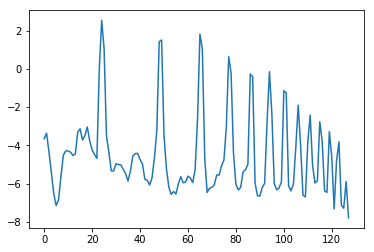

mallet


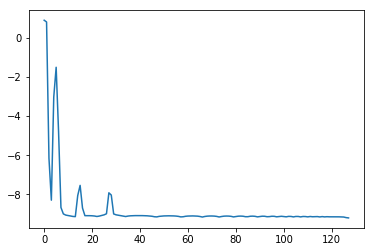

keyboard


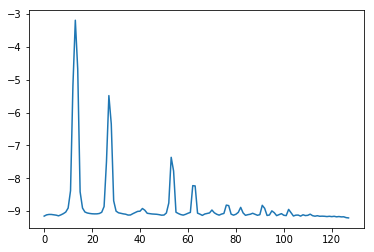

reed


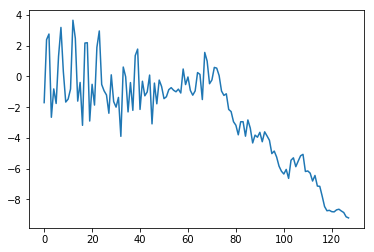

keyboard


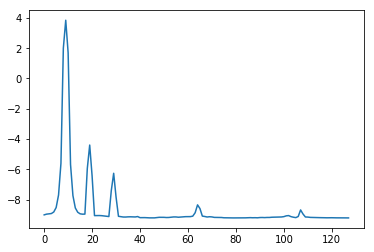

guitar


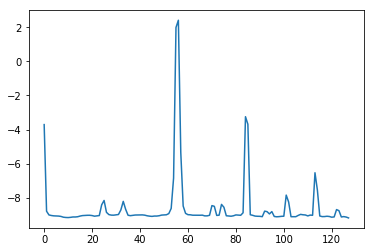

keyboard


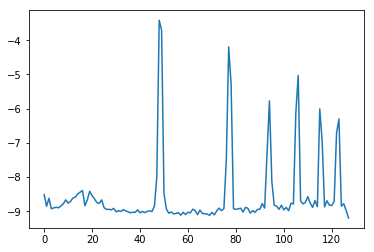

mallet


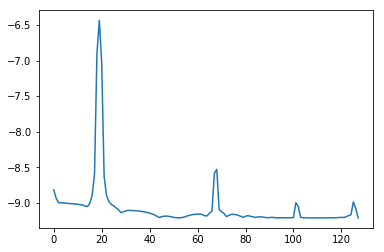

mallet


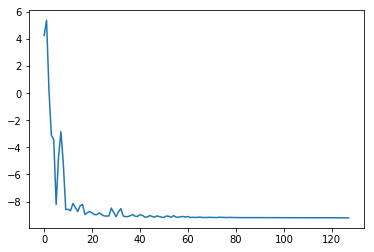

flute


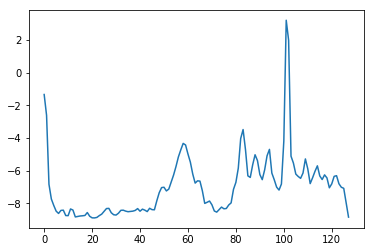

bass


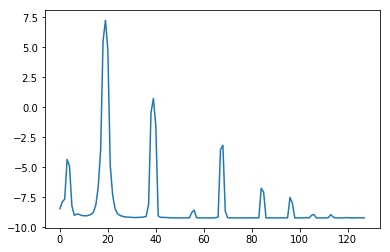

mallet


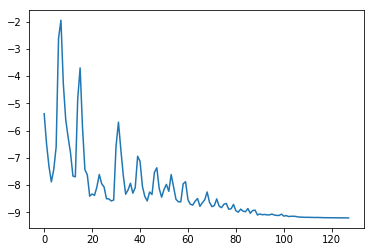

mallet


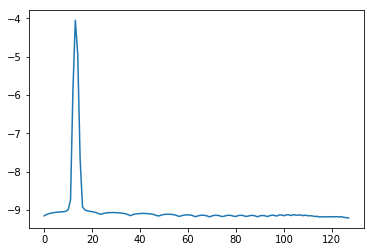

organ


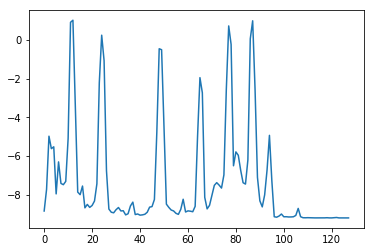

organ


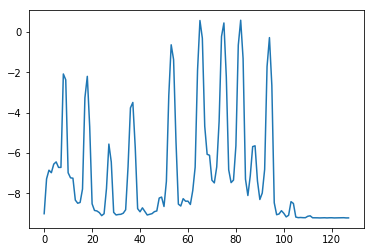

flute


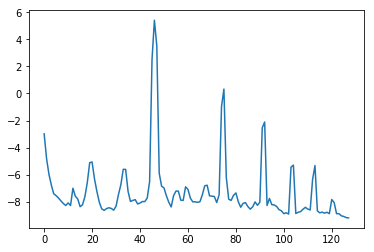

In [5]:
def computeMelspectrogram(numpyArray, sample_rate):
    S = librosa.feature.melspectrogram(y=numpyArray, sr=sample_rate, n_mels=128, fmax=8000)
    return np.log(S+1e-4)
sample_rate = 16000

batch_size = 16
trainLoader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
mfccs = np.zeros((batch_size, 128))
for samples, instrumentsFamily in trainLoader:
    for index, sample in enumerate(samples):
        mfccs[index] = np.mean(computeMelspectrogram(sample.numpy(), sample_rate), axis=1)
    family = trainDataset.transformInstrumentsFamilyToString(instrumentsFamily.numpy().astype(int))
    break # SVM is only fitted to a fixed size of data

import matplotlib.pyplot as plt
    
for i in range(batch_size):
    plt.plot(mfccs[i])
    print(family[i])
    plt.show()

So now that we have some features that make more sense, let's train a SVM on these. Notice that now we are using the full duration of the signals, but still reduced them from 64k samples to 128 features.

In [6]:
informedFamilyClassifier = svm.SVC()

trainLoader = data.DataLoader(trainDataset, batch_size=6400, shuffle=True)
start = time.time()
for samples, instrumentsFamily in trainLoader:
    mfccs = np.zeros((len(samples), 128))
    for index, sample in enumerate(samples.data):
        mfccs[index] = np.mean(computeMelspectrogram(sample.numpy(), sample_rate), axis=1)
    informedFamilyClassifier.fit(mfccs, instrumentsFamily.numpy())
    break # SVM is only fitted to a fixed size of data
    
print("Fitting the SVM took " + str((time.time()-start)/60) + "mins")

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitting the SVM took 1.8510383009910583mins


In [7]:
batch_size = 32
testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! Shuffle should be false

informedFamilyPredictions = np.zeros(len(testDataset), dtype=np.int)
start = time.time()
for index, samples in enumerate(testloader):
    mfccs = np.zeros((len(samples), 128))
    for inner_index, sample in enumerate(samples.data):
        mfccs[inner_index] = np.mean(computeMelspectrogram(sample.numpy(), sample_rate), axis=1)
    informedFamilyPredictions[index*batch_size:(index+1)*batch_size] = informedFamilyClassifier.predict(mfccs)

print("Classifying took " + str((time.time()-start)/60) + "mins")

Classifying took 0.9357314268747966mins


The training and the testing both were considerably faster. This model could be easily be trained on more samples (which we have!)

In [8]:
informedFamilyPredictionStrings = trainDataset.transformInstrumentsFamilyToString(informedFamilyPredictions.astype(int))

with open('SVM-informed-submission.csv', 'w', newline='') as writeFile:
    fieldnames = ['Id', 'Expected']
    writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    for index in range(len(testDataset)):
        writer.writerow({'Id': index, 'Expected': informedFamilyPredictionStrings[index]})


This model is also benchmarked and it has a performance of 0.39 F-score. Quite good on 10 classes! And it's a pretty small model! 